In [1]:
%pip install geopandas shapely pyproj folium
%pip install cdsapi
%pip install -U ecmwf-datastores-client
import sys
import subprocess

# Install netCDF4 if not already installed
subprocess.check_call([sys.executable, "-m", "pip", "install", "netCDF4"])


# Libraries
import os
from ecmwf.datastores import Client
from IPython.display import display

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!jupyter trust "download_daily_temp_era5.ipynb.ipynb"


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-trust` not found.


In [ ]:
import geopandas as gpd

# Load shapefile
shp_path = "../../data/raw/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path)

# Ensure projection is lat/lon (WGS84)
gdf = gdf.to_crs(epsg=4326)

# Get bounding box
minx, miny, maxx, maxy = gdf.total_bounds

# ERA5 format: [North, West, South, East]
bbox = [maxy, minx, miny, maxx]

print("ERA5 bbox:", bbox)

In [4]:
# convert to float
bbox = [float(x) for x in bbox]
print("ERA5 bbox (clean):", bbox)


ERA5 bbox (clean): [12.500951000000157, -1.6843399999999065, 12.259243999999967, -1.4119559999999183]


In [5]:
# display box on map to double-check - image saved to folder
import folium
from shapely.geometry import box
import geopandas as gpd


# Keep only geometry to avoid Timestamp serialization errors
gdf_geom = gdf[["geometry"]]

# Use existing bbox variable
north, west, south, east = bbox
bbox_polygon = box(west, south, east, north)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326")

# Center map on bbox
map_center = [(north + south)/2, (west + east)/2]
m = folium.Map(location=map_center, zoom_start=12, tiles="OpenStreetMap")

# Add city boundary (blue)
folium.GeoJson(
    gdf_geom,
    name="Ouagadougou Boundary",
    style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0}
).add_to(m)

# Add ERA5 bbox (red)
folium.GeoJson(
    bbox_gdf,
    name="ERA5 bbox",
    style_function=lambda x: {"color": "red", "weight": 2, "fillOpacity": 0.3}
).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Display map
m
m.save("ouagadougou_bbox_map.html")
print("Map saved as ouagadougou_bbox_map.html. Open this file in your browser to view it.")



Map saved as ouagadougou_bbox_map.html. Open this file in your browser to view it.


In [ ]:
import os
import cdsapi

# NOTE: Set CDSAPI_RC to the path of your Copernicus CDS API key file
# e.g. os.environ['CDSAPI_RC'] = os.path.expanduser('~/.cdsapirc')
client = cdsapi.Client()
print("CDS client initialized successfully")

In [ ]:
import cdsapi
import os

# === CONFIG ===
DATADIR = "./"
os.makedirs(DATADIR, exist_ok=True)

# NOTE: Set CDSAPI_RC to the path of your Copernicus CDS API key file
# e.g. os.environ['CDSAPI_RC'] = os.path.expanduser('~/.cdsapirc')

client = cdsapi.Client()
print("CDS client initialized successfully")

# === REFINED BBOX ===
# North, West, South, East
bbox = [12.5, -1.7, 12.3, -1.4]
print("Using bounding box:", bbox)

# === DOWNLOAD ONE YEAR ===
annee = '2024'
output_file = os.path.join(DATADIR, f"Era5_land_{annee}_Ouagadougou_daily_test.zip")

if os.path.exists(output_file):
    print(f"Already exists: {output_file}")
else:
    try:
        request = {
            "variable": ["2m_temperature"],
            "year": annee,
            "month": [f"{i:02d}" for i in range(1, 13)],
            "day": [f"{i:02d}" for i in range(1, 32)],
            "daily_statistic": "daily_maximum",
            "time_zone": "utc+00:00",
            "frequency": "1_hourly",
            "area": bbox
        }

        client.retrieve("derived-era5-land-daily-statistics", request).download(output_file)
        print(f"Downloaded: {output_file}")

    except Exception as e:
        print(f"Failed {annee}: {e}")

In [ ]:
import xarray as xr

ds = xr.open_dataset(os.path.join(DATADIR, "Era5_land_2024_Ouagadougou_daily_test.zip"))  # or rename .zip to .nc
print(ds.latitude.values)
print(ds.longitude.values)

In [ ]:

import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# === Load ERA5 dataset ===
FILE = "Era5_land_2024_Ouagadougou_daily_test.zip"
ds = xr.open_dataset(FILE)

# === Load Ouagadougou shapefile ===
shp_path = "../../data/raw/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

# === Detect coordinate names ===
lat_name = [v for v in ds.coords if "lat" in v.lower()][0]
lon_name = [v for v in ds.coords if "lon" in v.lower()][0]

lats = ds[lat_name].values
lons = ds[lon_name].values

print("Grid latitudes:", lats)
print("Grid longitudes:", lons)

# === Infer grid resolution ===
grid_res_lat = np.abs(np.diff(lats)).mean()
grid_res_lon = np.abs(np.diff(lons)).mean()
grid_res = (grid_res_lat + grid_res_lon) / 2

print(f"Inferred resolution: {grid_res:.3f}°")

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 10))

# Plot shapefile
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black', linewidth=2)

# Plot grid cells from dataset
for lat in lats:
    for lon in lons:
        rect = Rectangle(
            (lon - grid_res/2, lat - grid_res/2),
            grid_res, grid_res,
            linewidth=1.5, edgecolor='red',
            facecolor='red', alpha=0.3
        )
        ax.add_patch(rect)
        
        # Center point
        ax.plot(lon, lat, 'ro', markersize=8)

        # Label
        ax.text(lon, lat + 0.01, f"({lon:.3f}, {lat:.3f})",
                fontsize=8, ha='center',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# Zoom to shape area
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.1, maxx + 0.1)
ax.set_ylim(miny - 0.1, maxy + 0.1)

# Layout
ax.set_aspect("equal")
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("ERA5-Land Grid from Dataset over Ouagadougou", fontsize=14, weight="bold")

plt.grid(alpha=0.3)
plt.show()

Shapefile bounds: lon [-1.6843, -1.4120], lat [12.2592, 12.5010]

Total grid cells that intersect shapefile: 11

Intersecting latitudes: [np.float64(12.3), np.float64(12.4), np.float64(12.5)]
Intersecting longitudes: [np.float64(-1.7000000000000002), np.float64(-1.6), np.float64(-1.5), np.float64(-1.4)]

Optimal ERA5-Land bounding box [N, W, S, E]: [np.float64(12.5), np.float64(-1.7000000000000002), np.float64(12.3), np.float64(-1.4)]


/var/folders/zh/vv_ph5h91yzf_q6cpgm75d1c0000gn/T/ipykernel_904/888168259.py:31: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapefile_union = gdf.unary_union


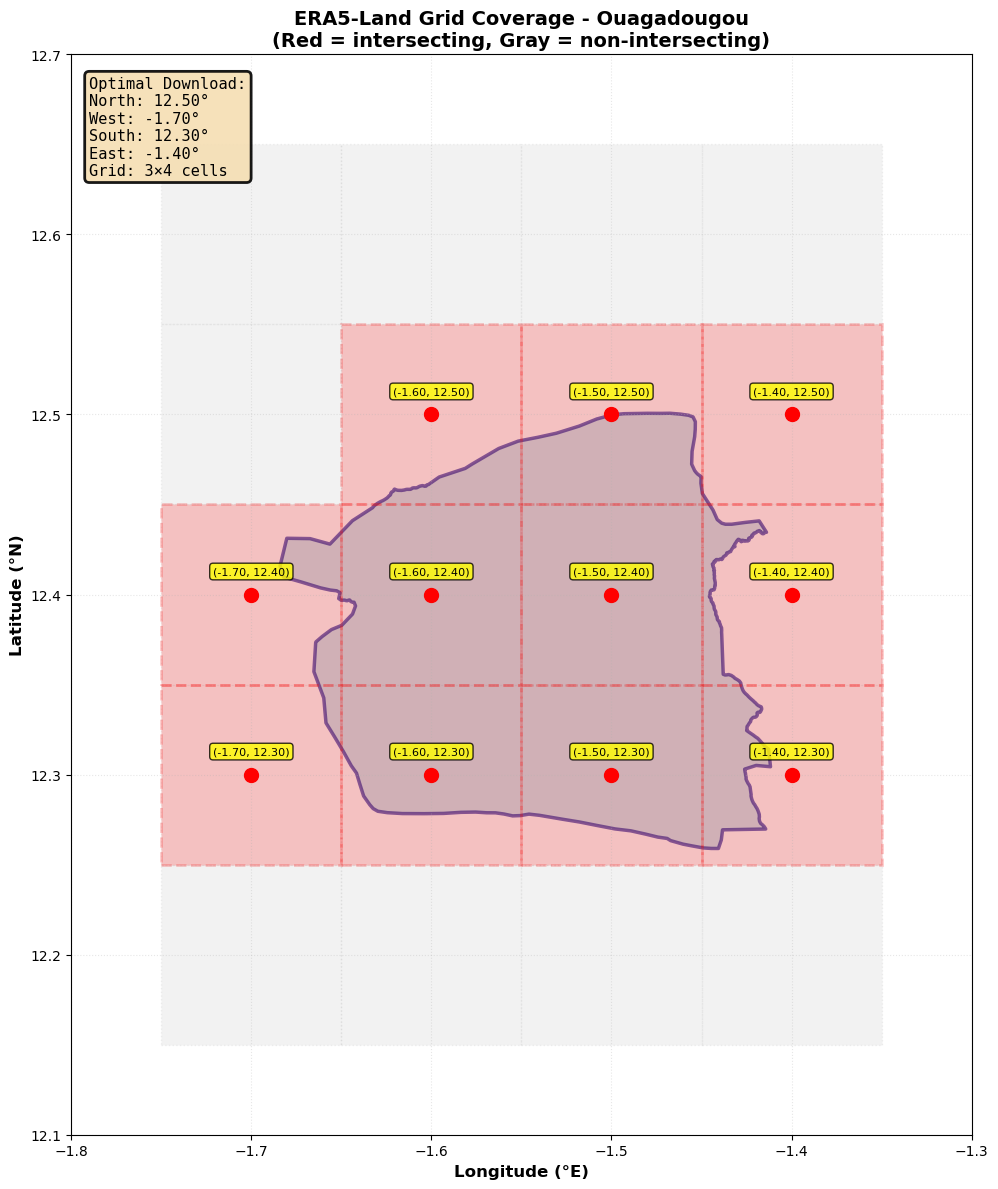


OPTIMAL DOWNLOAD COORDINATES
North: 12.5
West: -1.7000000000000002
South: 12.3
East: -1.4


In [ ]:
import cdsapi
import os

# === CONFIG ===
DATADIR = "./"
os.makedirs(DATADIR, exist_ok=True)

# NOTE: Set CDSAPI_RC to the path of your Copernicus CDS API key file
# e.g. os.environ['CDSAPI_RC'] = os.path.expanduser('~/.cdsapirc')

client = cdsapi.Client()
print("CDS client initialized successfully")
bbox = [12.5, -1.7, 12.3, -1.4]
print("Using bounding box:", bbox)  # use the previously defined bbox variable

# === YEARS ===
baseline_years = list(map(str, range(2001, 2021)))  # 2001–2020
target_year = ['2024']                               # target year
Annees = baseline_years + target_year

# === DOWNLOAD LOOP: one file per year ===
for annee in Annees:

    output_file = os.path.join(DATADIR, f"Era5_land_{annee}_Ouagadougou_daily.zip")

    if os.path.exists(output_file):
        print(f"Already exists: {output_file}")
        continue

    try:
        request = {
            "variable": ["2m_temperature"],
            "year": annee,
            "month": [f"{i:02d}" for i in range(1, 13)],  # all months
            "day": [f"{i:02d}" for i in range(1, 32)],     # all possible days
            "daily_statistic": "daily_maximum",
            "time_zone": "utc+00:00",
            "frequency": "1_hourly",
            "area": bbox  # use the existing bbox variable
        }

        client.retrieve("derived-era5-land-daily-statistics", request).download(output_file)
        print(f"Downloaded: {output_file}")

    except Exception as e:
        print(f"Failed {annee}: {e}")


import sys
import subprocess
import importlib

# Function to install a package if it's missing
def install_if_missing(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Ensure netCDF4 is installed
install_if_missing("netCDF4")

import xarray as xr
import glob
import os

In [ ]:
# Changed from zip to nc in terminal before as there was some issue with the zip ending
# for f in *.zip; do mv "$f" "${f%.zip}.nc"; done

import xarray as xr
import glob
import os

data_dir = "."
output_file = os.path.join(data_dir, "Ouagadougou_1991_2024_daily.nc")

# Get all .nc files
files = sorted(glob.glob(os.path.join(data_dir, "Era5_land_*_Ouagadougou_daily.nc")))
print("Files found:", len(files))

# Open each file individually and concatenate
datasets = [xr.open_dataset(f) for f in files]
ds = xr.concat(datasets, dim='time')

# Save merged dataset
ds.to_netcdf(output_file)
print("Merged dataset written:", output_file)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Open merged dataset
data = xr.open_dataset("Ouagadougou_1991_2024_daily.nc")

# Plot first day
data["t2m"][0,:,:].plot()  # "t2m" might be "2m_temperature" depending on the variable name
plt.show()

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load ERA5-Land dataset
ds = xr.open_dataset("Ouagadougou_1991_2024_daily.nc")
print(ds)

# Load Ouagadougou shapefile
shp_path = "../../data/raw/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path)
gdf = gdf.to_crs(epsg=4326)  # Ensure lat/lon

# Get grid cell centers from ERA5-Land
lons = ds.longitude.values
lats = ds.latitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lons.min()-0.05, lons.max()+0.05, lats.min()-0.05, lats.max()+0.05])

# Plot Ouagadougou boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Plot ERA5-Land 3x3 grid points
ax.scatter(lon2d, lat2d, color='blue', s=100, label='ERA5-Land grid points')

# Title and legend
ax.set_title("ERA5-Land 3x3 grid over Ouagadougou")
plt.legend()
plt.show()

In [4]:



# Get bounding box of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds
print("Ouagadougou shapefile bounds:")
print(f"min longitude: {minx}, max longitude: {maxx}")
print(f"min latitude: {miny}, max latitude: {maxy}\n")

# Get ERA5-Land grid coordinates
lons = ds.longitude.values
lats = ds.latitude.values
print("ERA5-Land grid coordinates:")
print("Longitudes:", lons)
print("Latitudes:", lats, "\n")

# Optional: find which grid points fall inside the shapefile bounds
mask_lon = (lons >= minx) & (lons <= maxx)
mask_lat = (lats >= miny) & (lats <= maxy)
selected_lons = lons[mask_lon]
selected_lats = lats[mask_lat]

print("ERA5-Land grid points inside Ouagadougou bounding box:")
print("Longitudes:", selected_lons)
print("Latitudes:", selected_lats)


Ouagadougou shapefile bounds:
min longitude: -1.6843399999999065, max longitude: -1.4119559999999183
min latitude: 12.259243999999967, max latitude: 12.500951000000157

ERA5-Land grid coordinates:
Longitudes: [-1.7 -1.6 -1.5 -1.4]
Latitudes: [12.5 12.4 12.3] 

ERA5-Land grid points inside Ouagadougou bounding box:
Longitudes: [-1.6 -1.5]
Latitudes: [12.5 12.4 12.3]


In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xarray as xr

# === Load ERA5 dataset ===
ds = xr.open_dataset("Ouagadougou_1991_2024_daily.nc")

era_lats = ds.latitude.values
era_lons = ds.longitude.values

print("ERA5 latitudes:", era_lats)
print("ERA5 longitudes:", era_lons)

# === Load shapefile ===
shp_path = "../../data/raw/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

# === Extract shapefile bounds ===
minx, miny, maxx, maxy = gdf.total_bounds
print(f"Shapefile bounds: lon [{minx:.4f}, {maxx:.4f}], lat [{miny:.4f}, {maxy:.4f}]")

# === ERA5 grid resolution (from the dataset) ===
grid_res = float(np.abs(era_lats[1] - era_lats[0]))
print("ERA5 grid resolution:", grid_res)

selected_lats = era_lats
selected_lons = era_lons

# === Create Visualization ===
fig, ax = plt.subplots(figsize=(14, 12))

# Plot shapefile
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='darkblue',
         linewidth=2.5, alpha=0.6)

# Plot each ERA5 grid cell
for lat in selected_lats:
    for lon in selected_lons:
        rect = Rectangle(
            (lon - grid_res/2, lat - grid_res/2),
            grid_res, grid_res,
            linewidth=1.5, edgecolor='red',
            facecolor='red', alpha=0.1, linestyle='--'
        )
        ax.add_patch(rect)
        ax.plot(lon, lat, 'ro', markersize=10, zorder=5)

# Add coordinate labels
for lat in selected_lats:
    for lon in selected_lons:
        ax.text(lon, lat + 0.01, f"({lon:.2f}, {lat:.2f})",
                fontsize=8, ha='center',
                bbox=dict(boxstyle='round,pad=0.3',
                          facecolor='yellow', alpha=0.8))

# Draw shapefile bounding box (green dashed)
ax.plot([minx, maxx, maxx, minx, minx],
        [miny, miny, maxy, maxy, miny],
        'g--', linewidth=2, label="Shapefile bbox")

# Plot formatting
padding = 0.08
ax.set_xlim(min(selected_lons) - padding, max(selected_lons) + padding)
ax.set_ylim(min(selected_lats) - padding, max(selected_lats) + padding)

ax.set_xlabel("Longitude (°E)", fontsize=12, fontweight="bold")
ax.set_ylabel("Latitude (°N)", fontsize=12, fontweight="bold")
ax.set_title("Actual ERA5-Land Grid Points Covering Ouagadougou", fontsize=14, fontweight="bold")

ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(loc="upper right", fontsize=10)
ax.set_aspect("equal")

# Add text box
textstr = f"ERA5 Grid:\nLatitudes: {len(selected_lats)}\nLongitudes: {len(selected_lons)}\nResolution: {grid_res}°"
ax.text(0.02, 0.98, textstr, transform=ax.transAxes,
        fontsize=11, va='top',
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.9))

plt.tight_layout()
plt.show()

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load ERA5-Land dataset
ds = xr.open_dataset("Ouagadougou_1991_2024_daily.nc")

# Load Ouagadougou shapefile
shp_path = "../../data/raw/Shapefile Ouaga/Ouaga.shp"
gdf = gpd.read_file(shp_path)
gdf = gdf.to_crs(epsg=4326)  # Ensure lat/lon

# Get grid cell centers from ERA5-Land
lons = ds.longitude.values
lats = ds.latitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lons.min()-0.05, lons.max()+0.05, lats.min()-0.05, lats.max()+0.05])

# Plot Ouagadougou boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Plot ERA5-Land 3x3 grid points
ax.scatter(lon2d, lat2d, color='blue', s=100, label='ERA5-Land grid points')

# Title and legend
ax.set_title("ERA5-Land 3x3 grid over Ouagadougou")
plt.legend()
plt.show()